In [ ]:
## Ultrasound nerve segmentation project

In [ ]:
Train a simple deep FCN for ultrasound nerve segmentation.

In [1]:
# import required stuff
from __future__ import print_function
import keras
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Cropping2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import merge, Add
from keras.optimizers import Adam
from keras import backend as K

import utils; reload(utils)
from utils import *

import os

import numpy as np

from skimage.transform import resize
from skimage.io import imsave, imread
from tqdm import tqdm

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
print (K.image_dim_ordering())

th


Here we define our loss function using Dice coefficient:

In [2]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
input_shape  = (1, 128, 128)
image_size   = input_shape[1:3]
weight_decay = 1e-6
classes      = 1

data_path       = 'data/'
orig_image_rows = 420
orig_image_cols = 580
image_rows      = image_size[0]
image_cols      = image_size[1]

Let's define our network architecture similar to a VGG16 FCN-8s:

In [13]:
# Create the FCN model
def get_vgg(input_shape, weight_decay=0.001, drop=0.5):
    
    input_img = Input(shape=input_shape)
    #bn_input  = BatchNormalization(axis=1)(input_img)
    
    # Block 1
    block1_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(input_img)
    block1_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(block1_conv1)
    block1_pool  = MaxPooling2D((2, 2), strides=(2, 2),  name='block1_pool')(block1_conv2)

    # Block 2
    block2_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(block1_pool)
    block2_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(block2_conv1)
    block2_pool  = MaxPooling2D((2, 2), strides=(2, 2),   name='block2_pool')(block2_conv2)

    # Block 3
    block3_conv1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(block2_pool)
    block3_conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(block3_conv1)
    block3_conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(block3_conv2)
    block3_pool  = MaxPooling2D((2, 2), strides=(2, 2),   name='block3_pool')(block3_conv3)

    # Block 4
    block4_conv1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(block3_pool)
    block4_conv2 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(block4_conv1)
    block4_conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(block4_conv2)
    block4_pool  = MaxPooling2D((2, 2), strides=(2, 2),   name='block4_pool')(block4_conv3)

    # Convolutional layers transfered from fully-connected layers
    fc1          = Conv2D(512, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(block4_pool)
    drop1        = Dropout(drop, name='drop1')(fc1)
    fc2          = Conv2D(512, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(drop1)
    drop2        = Dropout(drop, name='drop2')(fc2)

    #classifying layer
    conv7   = Conv2D(classes, (1, 1), activation='relu', padding='valid', name='conv7', strides=(1, 1), kernel_regularizer=l2(weight_decay))(drop2)
    
    #upsample once                
    decoder7 = Conv2DTranspose(classes, 4, strides=(2,2), padding='valid', activation='relu', name='decoder7')(conv7)
    
    #convert pool3 to scoring layer 
    score3    = Conv2D(classes, (1, 1), activation='relu', padding='same',  name='score3', strides=(1, 1), kernel_regularizer=l2(weight_decay))(block3_pool)   
    
    #crop decoder7 to same size as score3
    crop_size7 = (decoder7._keras_shape[2] - score3._keras_shape[2])/2
    print(crop_size7)
    crop7 = Cropping2D( cropping=crop_size7, name='crop7' )(decoder7)
    
    #1st merge: score4 and crop_7
    added1 = Add()([score3, crop7])
    
    # Upsample again
    decoder8 = Conv2DTranspose(classes, 4, strides=(2,2), padding='valid', activation='relu', name='decoder8')(added1)
    
    #convert pool2 to scoring layer 
    score2    = Conv2D(classes, (1, 1), activation='relu', padding='same', name='score2', strides=(1, 1), kernel_regularizer=l2(weight_decay))(block2_pool) 

    #crop decoder8 to same size as score3
    crop_size8 = (decoder8._keras_shape[2] - score2._keras_shape[2])/2
    print(crop_size8)
    crop8 = Cropping2D( cropping=crop_size8, name='crop8' )(decoder8)
    
    # 2nd merge: score3 and crop8
    added2 = Add()([score2, crop8])
    
    # Final upsampling
    decoder9 = Conv2DTranspose(classes, 16, strides=(4,4), padding='valid', name='decoder_layer3', activation='sigmoid')(added2)
    
    # Crop to original size
    crop_size9 = (decoder9._keras_shape[2] - input_shape[2])/2
    print(crop_size9)
    crop9 = Cropping2D( cropping=crop_size9, name='crop9' )(decoder9)
    
    #setup final model
    model = Model(inputs=[input_img], outputs=crop9)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    
    return model

In [4]:
def get_unet():
    inputs = Input((1, image_rows, image_cols))
    #bn_input  = BatchNormalization(axis=1)(inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-5), loss='mean_absolute_error')

    return model

In [6]:
#model = get_vgg(input_shape, weight_decay)
model = get_unet()
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 128, 128)  320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 128, 128)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 64, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

## Prepare data

In [5]:
def create_train_data():
    train_data_path = os.path.join(data_path, 'train_clean')
    images = os.listdir(train_data_path)
    total = len(images) / 2

    imgs      = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)
    imgs_mask = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

    i = 0
    print('Create training images...')
    for image_name in tqdm(images):
        if 'mask' in image_name:
            continue
            
        image_mask_name = image_name.split('.')[0] + '_mask.png'
        img = imread(os.path.join(train_data_path, image_name), as_grey=True) 
        img_mask =  imread(os.path.join(train_data_path, image_mask_name), as_grey=True)
        
        #Resize images
        img      = resize(img,      (image_cols, image_rows), preserve_range=True)
        img_mask = resize(img_mask, (image_cols, image_rows), preserve_range=True)
        #img      = cv2.resize(img,     (image_cols,image_rows), interpolation=cv2.INTER_AREA)
        #img_mask = cv2.resize(img_mask,(image_cols,image_rows), interpolation=cv2.INTER_AREA)

        img = np.expand_dims(np.array(img), axis=2)
        img_mask = np.expand_dims(np.array(img_mask), axis=2)

        imgs[i] = img
        imgs_mask[i] = img_mask
        
        i += 1

    print('Loading done.')

    np.save('imgs_train.npy', imgs)
    np.save('imgs_mask_train.npy', imgs_mask)
    print('Saving to .npy files done.')


def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train


def create_test_data():
    test_data_path = os.path.join(data_path, 'test')
    images = os.listdir(test_data_path)
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)
    imgs_id = np.ndarray((total, ), dtype=np.int32)

    i = 0
    print('Create test images...')
    for image_name in tqdm(images):
        img_id = int(image_name.split('.')[0])
        img = imread(os.path.join(test_data_path, image_name), as_grey=True) 
        
        #Resize images
        #img      = cv2resize(img,(image_cols,image_rows), interpolation=cv2.INTER_AREA)
        img      = resize(img, (image_cols, image_rows), preserve_range=True)

        img = np.expand_dims(np.array(img), axis=2)

        imgs[i] = img
        imgs_id[i] = img_id
        
        i += 1
    print('Loading done.')

    np.save('imgs_test.npy', imgs)
    np.save('imgs_id_test.npy', imgs_id)
    print('Saving to .npy files done.')


def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_id = np.load('imgs_id_test.npy')
    return imgs_test, imgs_id

In [33]:
# Save train and test data to numpy arrays
create_train_data()
create_test_data()

  0%|          | 12/7812 [00:00<01:07, 115.15it/s]

Create training images...


100%|██████████| 7812/7812 [00:48<00:00, 161.42it/s]


Loading done.


  0%|          | 4/5508 [00:00<02:57, 30.99it/s]

Saving to .npy files done.
Create test images...


 22%|██▏       | 1208/5508 [00:42<02:31, 28.46it/s]/home/ubuntu/anaconda2/lib/python2.7/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5508/5508 [03:20<00:00, 27.46it/s]


Loading done.
Saving to .npy files done.


In [6]:
import random
import numpy as np
#from scipy.misc import imread, imresize
from sklearn.utils import shuffle
from keras.preprocessing.image import (transform_matrix_offset_center, apply_transform, Iterator,
random_channel_shift, flip_axis)

BATCH_SIZE = 64
rotation_range = np.deg2rad(5.)
height_shift_range = 0.04
width_shift_range = 0.04
shear_range = np.deg2rad(5.)
zoom_range = (0.9, 1.1)
channel_shift_range = 5.


def generate_data_from_file(imgs, masks):
    
    total = len(imgs)
    
    num_batches  = total // BATCH_SIZE
    assert(num_batches > 0)
    
    x = np.ndarray((BATCH_SIZE, 1, image_rows, image_cols), dtype=np.float32)
    y = np.ndarray((BATCH_SIZE, 1, image_rows, image_cols), dtype=np.float32)
    
    while True:
        
        # Shuffle data once in every epoch
        traverse_indexes = np.arange(total)
        np.random.shuffle(traverse_indexes)
        #imgs, masks = shuffle(imgs, masks, random_state=0, n_samples=total)
        
        for batch in range(num_batches):
            
            startIdx = batch*BATCH_SIZE
            for batchIdx in range(BATCH_SIZE):
                 
                # Get next image
                array_idx = startIdx + batchIdx
                image_idx = traverse_indexes[array_idx]
                assert(image_idx >= 0)
                assert(image_idx < len(imgs))
        
                # Get image and label
                img = imgs[image_idx]
                img_mask = masks[image_idx]
                
                # Augment training data      
                # use composition of homographies to generate final transform that needs to be applied
                theta = np.random.uniform(-rotation_range, rotation_range)
                rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                            [np.sin(theta), np.cos(theta), 0],
                                            [0, 0, 1]])
                tx = np.random.uniform(-height_shift_range, height_shift_range)*image_cols
                ty = np.random.uniform(-width_shift_range, width_shift_range)*image_rows

                translation_matrix = np.array([[1, 0, tx],
                                               [0, 1, ty],
                                               [0, 0, 1]])
                
                shear = np.random.uniform(shear_range, shear_range)
                shear_matrix = np.array([[1, -np.sin(shear), 0],
                                         [0, np.cos(shear), 0],
                                         [0, 0, 1]])

                zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
                zoom_matrix = np.array([[zx, 0, 0],
                                        [0, zy, 0],
                                        [0, 0, 1]])

                transform_matrix = np.dot(np.dot(np.dot(rotation_matrix, translation_matrix), shear_matrix), zoom_matrix)
        
                h, w = image_rows, image_cols
                transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        
                img = apply_transform(img, transform_matrix, 0,
                                    fill_mode='constant')
                img_mask = apply_transform(img_mask, transform_matrix, 0,
                                    fill_mode='constant')
               

                if np.random.random() < 0.5:
                    img = flip_axis(img, 1)
                    img_mask = flip_axis(img_mask, 1)
                    
                #img = random_channel_shift(img, channel_shift_range)
                
                # Fill generator output data
                x[batchIdx,:,:,:] = img
                y[batchIdx,:,:,:] = img_mask
                
        yield(x, y)

In [7]:
continue_train = False

# Split training data 
from sklearn.cross_validation import train_test_split

imgs_train, imgs_mask_train = load_train_data()

# Data preprocessing for all data
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

X_train, X_valid, y_train, y_valid = train_test_split(
       imgs_train, imgs_mask_train, test_size=0.1, random_state=42)

X_train = np.reshape(X_train, (len(X_train), 1, image_rows, image_cols))
X_valid = np.reshape(X_valid, (len(X_valid), 1, image_rows, image_cols))
y_train = np.reshape(y_train, (len(y_train), 1, image_rows, image_cols))
y_valid = np.reshape(y_valid, (len(y_valid), 1, image_rows, image_cols))

In [28]:
y_valid.shape

(391, 1, 128, 128)

Debug outputs:

In [ ]:
print(steps_per_train_epoch)
print(steps_per_train_epoch*BATCH_SIZE)
print(len(X_train))

In [44]:
print(X_train.shape)
print(y_train.shape)
x_t, y_t = generate_data_from_file(X_train, y_train).next()

(3515, 1, 128, 128)
(3515, 1, 128, 128)


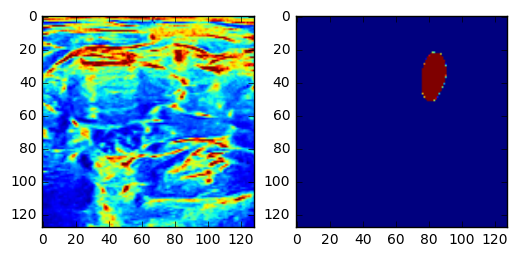

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

random_num = np.random.randint(0,len(X_valid))
fig = plt.figure()
a = fig.add_subplot(1,2,1)
#img = x_t[15,:,:,:]
img = X_train[random_num,:,:,:]
plt.imshow(np.squeeze(img))

a = fig.add_subplot(1,2,2)
#img2 = y_t[15,:,:,:]
img2 = np.reshape(y_train[random_num,:,:,:],(128,128,1))
plt.imshow(np.squeeze(img2))

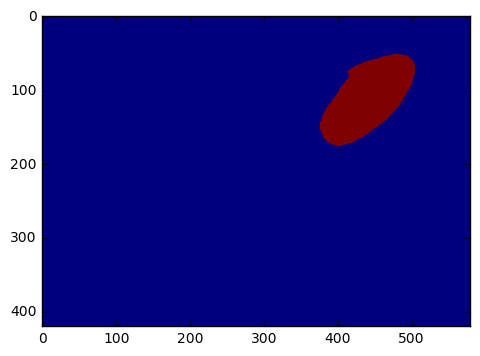

In [12]:
train_data_path = os.path.join('data', 'train_clean')
images = os.listdir(train_data_path)
total = len(images) / 2

image_name = '20_89.png'
image_mask_name = image_name.split('.')[0] + '_mask.png'
img = imread(os.path.join(train_data_path, image_name), as_grey=True) 
img_mask =  imread(os.path.join(train_data_path, image_mask_name), as_grey=True)

plt.imshow(np.squeeze(img_mask))

# Train model

In [8]:
print('Creating and compiling model...')
#model = get_vgg(input_shape, weight_decay, 0.5)
model = get_unet()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
#K.set_value(model.optimizer.lr, 1e-3)

print('Fitting model...')
#if continue_train == True:
model.load_weights('weights.h5')
    
model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, shuffle=True,
          validation_data=(X_valid, y_valid),
          callbacks=[model_checkpoint])
    
#model.fit_generator( generate_data_from_file(X_train, y_train), 
 #                steps_per_epoch=steps_per_train_epoch, 
  #               nb_epoch=5, 
   #              verbose=1,
    #             validation_data=(X_valid, y_valid), 
     #            validation_steps=steps_per_valid_epoch,
      #           callbacks=[model_checkpoint] )

Creating and compiling model...
Fitting model...
Train on 3515 samples, validate on 391 samples
Epoch 1/30
3515/3515 [==============================] - 96s - loss: -0.5059 - dice_coef: 0.5059 - val_loss: -0.5090 - val_dice_coef: 0.5090
Epoch 2/30
3515/3515 [==============================] - 96s - loss: -0.5199 - dice_coef: 0.5199 - val_loss: -0.5226 - val_dice_coef: 0.5226
Epoch 3/30
3515/3515 [==============================] - 96s - loss: -0.5327 - dice_coef: 0.5327 - val_loss: -0.5345 - val_dice_coef: 0.5345
Epoch 4/30
3515/3515 [==============================] - 96s - loss: -0.5314 - dice_coef: 0.5314 - val_loss: -0.5270 - val_dice_coef: 0.5270
Epoch 5/30
3515/3515 [==============================] - 96s - loss: -0.5441 - dice_coef: 0.5441 - val_loss: -0.5582 - val_dice_coef: 0.5582
Epoch 6/30
3515/3515 [==============================] - 96s - loss: -0.5440 - dice_coef: 0.5440 - val_loss: -0.5614 - val_dice_coef: 0.5614
Epoch 7/30
3515/3515 [==============================] - 96s - lo

In [9]:
model.load_weights('weights.h5')
K.set_value(model.optimizer.lr, 1e-5)

model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1, shuffle=True,
          validation_data=(X_valid, y_valid),
          callbacks=[model_checkpoint])

Train on 3515 samples, validate on 391 samples
Epoch 1/20
3515/3515 [==============================] - 96s - loss: -0.6696 - dice_coef: 0.6696 - val_loss: -0.6628 - val_dice_coef: 0.6628
Epoch 2/20
3515/3515 [==============================] - 96s - loss: -0.6715 - dice_coef: 0.6715 - val_loss: -0.6626 - val_dice_coef: 0.6626
Epoch 3/20
3515/3515 [==============================] - 96s - loss: -0.6698 - dice_coef: 0.6698 - val_loss: -0.6631 - val_dice_coef: 0.6631
Epoch 4/20
3515/3515 [==============================] - 96s - loss: -0.6698 - dice_coef: 0.6698 - val_loss: -0.6544 - val_dice_coef: 0.6544
Epoch 5/20
3515/3515 [==============================] - 96s - loss: -0.6699 - dice_coef: 0.6699 - val_loss: -0.6651 - val_dice_coef: 0.6651
Epoch 6/20
3515/3515 [==============================] - 96s - loss: -0.6722 - dice_coef: 0.6722 - val_loss: -0.6659 - val_dice_coef: 0.6659
Epoch 7/20
3515/3515 [==============================] - 96s - loss: -0.6725 - dice_coef: 0.6725 - val_loss: -0.66

# Pseudo-Labeling

In [ ]:
# Load test data
print('Loading test images...')
imgs_test, imgs_id_test = load_test_data()
imgs_test = imgs_test.astype('float32')
imgs_test = np.reshape(imgs_test, (len(imgs_test), 1, image_rows, image_cols))

mean = np.mean(imgs_test)  # mean for data centering
std = np.std(imgs_test)  # std for data normalization

imgs_test -= mean
imgs_test /= std

print('Loading saved weights...')
model.load_weights('weights.h5')

print('Predicting masks on test data...')
preds = model.predict(imgs_test, batch_size=BATCH_SIZE*2, verbose=1)

gen = ImageDataGenerator()
test_batches = gen.flow(imgs_test, preds, batch_size=16)
val_batches = gen.flow(X_valid, y_valid, batch_size=4)
batches = gen.flow(X_train, y_train, batch_size=44)
mi = MixIterator([batches, test_batches, val_batches])
#mi = MixIterator([batches, test_batches])

model.load_weights('weights.h5')
K.set_value(model.optimizer.lr, 1e-5)
model.fit_generator(mi, mi.N//64, nb_epoch=8, validation_data=(X_valid, y_valid))

Loading test images...
Loading saved weights...
Predicting masks on test data...
5504/5508 [============================>.] - ETA: 0s

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<utils.Mix..., 147, epochs=8, validation_data=(array([[[...)`


Epoch 1/8
147/147 [==============================] - 252s - loss: -0.7206 - dice_coef: 0.7206 - val_loss: -0.6694 - val_dice_coef: 0.6694
Epoch 2/8
147/147 [==============================] - 252s - loss: -0.7407 - dice_coef: 0.7407 - val_loss: -0.6759 - val_dice_coef: 0.6759
Epoch 3/8
147/147 [==============================] - 251s - loss: -0.7421 - dice_coef: 0.7421 - val_loss: -0.6760 - val_dice_coef: 0.6760
Epoch 4/8
 36/147 [======>.......................] - ETA: 187s - loss: -0.7425 - dice_coef: 0.7425

In [30]:
model = get_unet()
model.load_weights('weights.h5')
preds = model.predict(X_valid, batch_size=BATCH_SIZE*2, verbose=1)

391/391 [==============================] - 3s     


In [31]:
def dice_np(y_true, y_pred):
    y_true_f = np.array(y_true)
    y_pred_f = np.array(y_pred)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice_scores = np.zeros((len(preds)))
for i in range(len(preds)):
    dice_scores[i] = dice_np(y_valid[i], preds[i])

In [32]:
print(dice_scores)

[ 0.8191  0.8682  0.0016  0.9752  0.9785  0.5587  0.9031  0.9889  0.9516  0.9301  0.0022  0.7307
  0.9764  0.9106  0.7869  0.9888  0.8123  0.6456  0.9233  0.9715  0.8771  0.0018  0.9792  0.9773
  0.9817  0.7499  0.8157  0.948   0.2323  0.988   0.9753  0.0482  0.6685  0.7981  0.6983  0.9423
  0.0041  0.9454  0.932   0.9855  0.8295  0.0045  0.0031  0.0149  0.0032  0.8131  0.0151  0.962
  0.9531  0.8419  0.7729  0.9764  0.0191  0.9379  0.9703  0.0014  0.3399  0.5986  0.881   0.7975
  0.6867  0.8649  0.0564  0.9519  0.9725  0.9906  0.944   0.9866  0.9624  0.778   0.9818  0.917
  0.7356  0.9521  0.9658  0.7237  0.9247  0.9711  0.9804  0.4683  0.002   0.9119  0.9679  0.9846
  0.7327  0.9686  0.9853  0.9283  0.9276  0.9936  0.8108  0.5909  0.825   0.9545  0.4359  0.0021
  0.8465  0.4706  0.9602  0.9783  0.8645  0.8261  0.983   0.9428  0.9831  0.96    0.7062  0.5772
  0.9104  0.9527  0.9548  0.9783  0.0017  0.7481  0.879   0.9935  0.9661  0.7371  0.9193  0.9788
  0.9416  0.9594  0.7743  0.9736

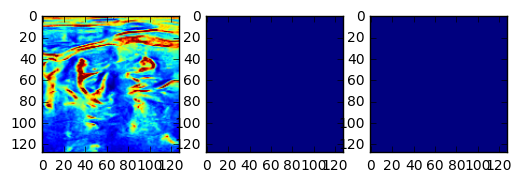

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

random_idx = np.random.randint(0,len(y_valid))

fig = plt.figure()
a = fig.add_subplot(1,3,1)
#img = x_t[15,:,:,:]
img = X_valid[random_idx]
plt.imshow(np.squeeze(img))

a = fig.add_subplot(1,3,2)
#img = x_t[15,:,:,:]
img2 = y_valid[random_idx]
plt.imshow(np.squeeze(img2))

a = fig.add_subplot(1,3,3)
#img2 = y_t[15,:,:,:]
img3 = preds[random_idx]
plt.imshow(np.squeeze(img3))

In [ ]:
## Show worst predictions
sorted_dice = np.argsort(dice_scores)
numImages = 5

for i in range(numImages):
    fig = plt.figure()
    idx = sorted_dice[i]
    
    a = fig.add_subplot(1,3,1)
    #img = x_t[15,:,:,:]
    img = X_valid[idx]
    plt.imshow(np.squeeze(img))

    a = fig.add_subplot(1,3,2)
    #img = x_t[15,:,:,:]
    img2 = y_valid[idx]
    plt.imshow(np.squeeze(img2))

    a = fig.add_subplot(1,3,3)
    #img2 = y_t[15,:,:,:]
    img3 = preds[idx]
    plt.imshow(np.squeeze(img3))

## Test model

In [36]:
print('Loading and preprocessing test data...')
imgs_test, imgs_id_test = load_test_data()

imgs_test = imgs_test.astype('float32')
imgs_test = np.reshape(imgs_test, (len(imgs_test), 1, image_rows, image_cols))
mean = np.mean(imgs_test)  # mean for data centering
std = np.std(imgs_test)  # std for data normalization
imgs_test -= mean
imgs_test /= std

print('Loading saved weights...')
#model = get_unet()
model.load_weights('weights.h5')

print('Predicting masks on test data...')
imgs_mask_test = model.predict(imgs_test, verbose=1)
np.save('imgs_mask_test.npy', imgs_mask_test)

Loading and preprocessing test data...
Loading saved weights...
Predicting masks on test data...
5504/5508 [============================>.] - ETA: 0s

In [37]:
import cv2

print('Saving predicted masks to files...')
pred_dir = 'preds'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for image, image_id in zip(imgs_mask_test, imgs_id_test):
    image = (np.squeeze(image) * 255.).astype(np.uint8)
    cv2.imwrite(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)

Saving predicted masks to files...


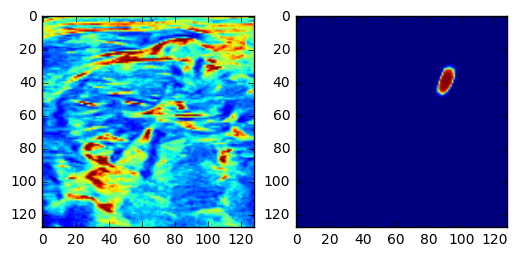

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
a = fig.add_subplot(1,2,1)
#img = x_t[15,:,:,:]
img = imgs_test[33,:,:,:]
plt.imshow(np.squeeze(img))

a = fig.add_subplot(1,2,2)
#img2 = y_t[15,:,:,:]
img2 = imgs_mask_test[33,:,:,:]
plt.imshow(np.squeeze(img2))

#print(img2)

## Submit 

In [45]:
def prep(img):
    img = img.astype('float32')
    img = (img > 0.5).astype(np.uint8)  # threshold
    img = np.reshape(img, (image_rows, image_cols,1))
    img = resize(img, (orig_image_rows, orig_image_cols), preserve_range=True)
    return img


def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])


def submission():
    imgs_test, imgs_id_test = load_test_data()
    imgs_test = np.load('imgs_mask_test.npy')

    argsort = np.argsort(imgs_id_test)
    imgs_id_test = imgs_id_test[argsort]
    imgs_test = imgs_test[argsort]

    total = imgs_test.shape[0]
    ids = []
    rles = []
    for i in range(total):
        img = imgs_test[i, 0]
        img = prep(img)
        rle = run_length_enc(img)

        rles.append(rle)
        ids.append(imgs_id_test[i])

        if i % 100 == 0:
            print('{}/{}'.format(i, total))

    first_row = 'img,pixels'
    file_name = 'submission.csv'

    with open(file_name, 'w+') as f:
        f.write(first_row + '\n')
        for i in range(total):
            s = str(ids[i]) + ',' + rles[i]
            f.write(s + '\n')

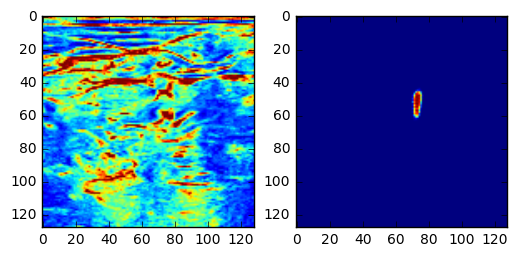

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

random_idx = np.random.randint(0,len(imgs_test))

fig = plt.figure()
a = fig.add_subplot(1,2,1)
#img = x_t[15,:,:,:]
img = imgs_test[random_idx]
plt.imshow(np.squeeze(img))

a = fig.add_subplot(1,2,2)
#img = x_t[15,:,:,:]
img2 = imgs_mask_test[random_idx]
plt.imshow(np.squeeze(img2))

In [46]:
# Create new submission file
submission()

0/5508
100/5508
200/5508
300/5508
400/5508
500/5508
600/5508
700/5508
800/5508
900/5508
1000/5508
1100/5508
1200/5508
1300/5508
1400/5508
1500/5508
1600/5508
1700/5508
1800/5508
1900/5508
2000/5508
2100/5508
2200/5508
2300/5508
2400/5508
2500/5508
2600/5508
2700/5508
2800/5508
2900/5508
3000/5508
3100/5508
3200/5508
3300/5508
3400/5508
3500/5508
3600/5508
3700/5508
3800/5508
3900/5508
4000/5508
4100/5508
4200/5508
4300/5508
4400/5508
4500/5508
4600/5508
4700/5508
4800/5508
4900/5508
5000/5508
5100/5508
5200/5508
5300/5508
5400/5508
5500/5508
